# PV Lakehouse Silver Layer - Comprehensive Data Quality Analysis
## Detailed validation of energy, radiation, weather, and air quality data

This notebook provides a thorough examination of data quality after loader updates, including:
- Physical constraints validation
- Temporal consistency checks  
- Energy-radiation correlation analysis
- Quality flag pattern analysis
- Distribution analysis and statistical anomalies
- Recommendations for data cleaning

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from scipy import stats
import warnings

warnings.filterwarnings('ignore')

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)

# Load datasets
print("Loading data files...")
energy_df = pd.read_csv('/home/pvlakehouse/dlh-pv/src/pv_lakehouse/exported_data/lh_silver_clean_hourly_energy.csv')
weather_df = pd.read_csv('/home/pvlakehouse/dlh-pv/src/pv_lakehouse/exported_data/lh_silver_clean_hourly_weather.csv')
air_df = pd.read_csv('/home/pvlakehouse/dlh-pv/src/pv_lakehouse/exported_data/lh_silver_clean_hourly_air_quality.csv')

print(f"Energy records: {len(energy_df):,}")
print(f"Weather records: {len(weather_df):,}")
print(f"Air Quality records: {len(air_df):,}")
print(f"\nEnergy columns: {list(energy_df.columns)}")
print(f"Weather columns: {list(weather_df.columns)}")
print(f"Air Quality columns: {list(air_df.columns)}")

Loading data files...
Energy records: 81,355
Weather records: 81,360
Air Quality records: 81,360

Energy columns: ['facility_code', 'facility_name', 'network_code', 'network_region', 'date_hour', 'energy_mwh', 'intervals_count', 'quality_flag', 'quality_issues', 'completeness_pct', 'created_at', 'updated_at']
Weather columns: ['facility_code', 'facility_name', 'timestamp', 'date_hour', 'date', 'shortwave_radiation', 'direct_radiation', 'diffuse_radiation', 'direct_normal_irradiance', 'temperature_2m', 'dew_point_2m', 'wet_bulb_temperature_2m', 'cloud_cover', 'cloud_cover_low', 'cloud_cover_mid', 'cloud_cover_high', 'precipitation', 'sunshine_duration', 'total_column_integrated_water_vapour', 'wind_speed_10m', 'wind_direction_10m', 'wind_gusts_10m', 'pressure_msl', 'is_valid', 'quality_flag', 'quality_issues', 'created_at', 'updated_at']
Air Quality columns: ['facility_code', 'facility_name', 'timestamp', 'date_hour', 'date', 'pm2_5', 'pm10', 'dust', 'nitrogen_dioxide', 'ozone', 'sulphu

## 1. Energy Generation Patterns by Facility & Time

Visualize daily patterns to identify anomalies like nighttime generation

In [2]:
# Convert timestamp and extract hour
energy_df['date_hour_dt'] = pd.to_datetime(energy_df['date_hour'])
energy_df['hour'] = energy_df['date_hour_dt'].dt.hour
energy_df['date'] = energy_df['date_hour_dt'].dt.date

# Calculate hourly averages by facility
hourly_by_facility = energy_df.groupby(['facility_code', 'hour']).agg({
    'energy_mwh': ['mean', 'std', 'min', 'max', 'count']
}).reset_index()

hourly_by_facility.columns = ['facility_code', 'hour', 'energy_mean', 'energy_std', 'energy_min', 'energy_max', 'count']

# Pivot for easier plotting
pivot_energy = hourly_by_facility.pivot(index='hour', columns='facility_code', values='energy_mean')

# Create linechart with Plotly
fig = go.Figure()
for facility in pivot_energy.columns:
    fig.add_trace(go.Scatter(
        x=pivot_energy.index,
        y=pivot_energy[facility],
        mode='lines+markers',
        name=facility,
        line=dict(width=2)
    ))

fig.update_layout(
    title='Average Hourly Energy Generation by Facility',
    xaxis_title='Hour of Day',
    yaxis_title='Energy (MWh)',
    hovermode='x unified',
    height=500,
    template='plotly_white'
)
fig.show()

print(f"Night Energy Analysis (22:00-06:00):")
night_hours = [22, 23, 0, 1, 2, 3, 4, 5, 6]
night_data = energy_df[energy_df['hour'].isin(night_hours)]
print(f"Total night records: {len(night_data):,}")
print(f"Night records with energy > 0: {len(night_data[night_data['energy_mwh'] > 0]):,}")
print(f"Night records with GOOD flag: {len(night_data[night_data['quality_flag'] == 'GOOD']):,}")
print(f"Night records with TEMPORAL_ANOMALY: {len(night_data[night_data['quality_flag'] == 'TEMPORAL_ANOMALY']):,}")

Night Energy Analysis (22:00-06:00):
Total night records: 30,505
Night records with energy > 0: 2,367
Night records with GOOD flag: 28,469
Night records with TEMPORAL_ANOMALY: 121


## 2. Distribution Analysis - Energy & Radiation

Box plots and histograms to identify outliers and distribution anomalies

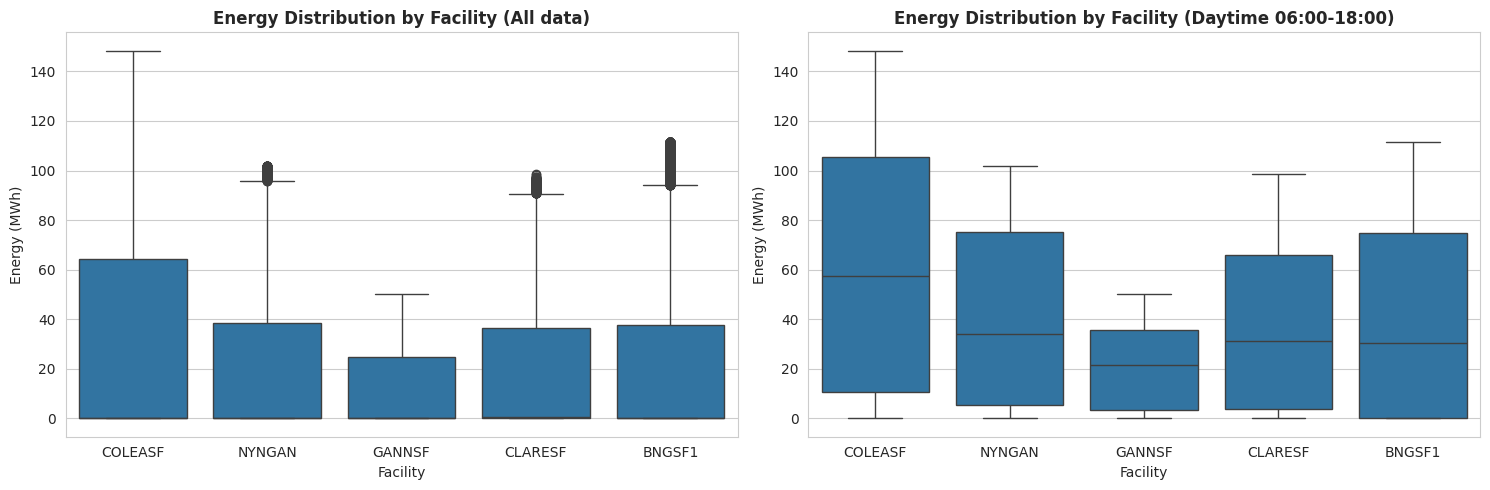

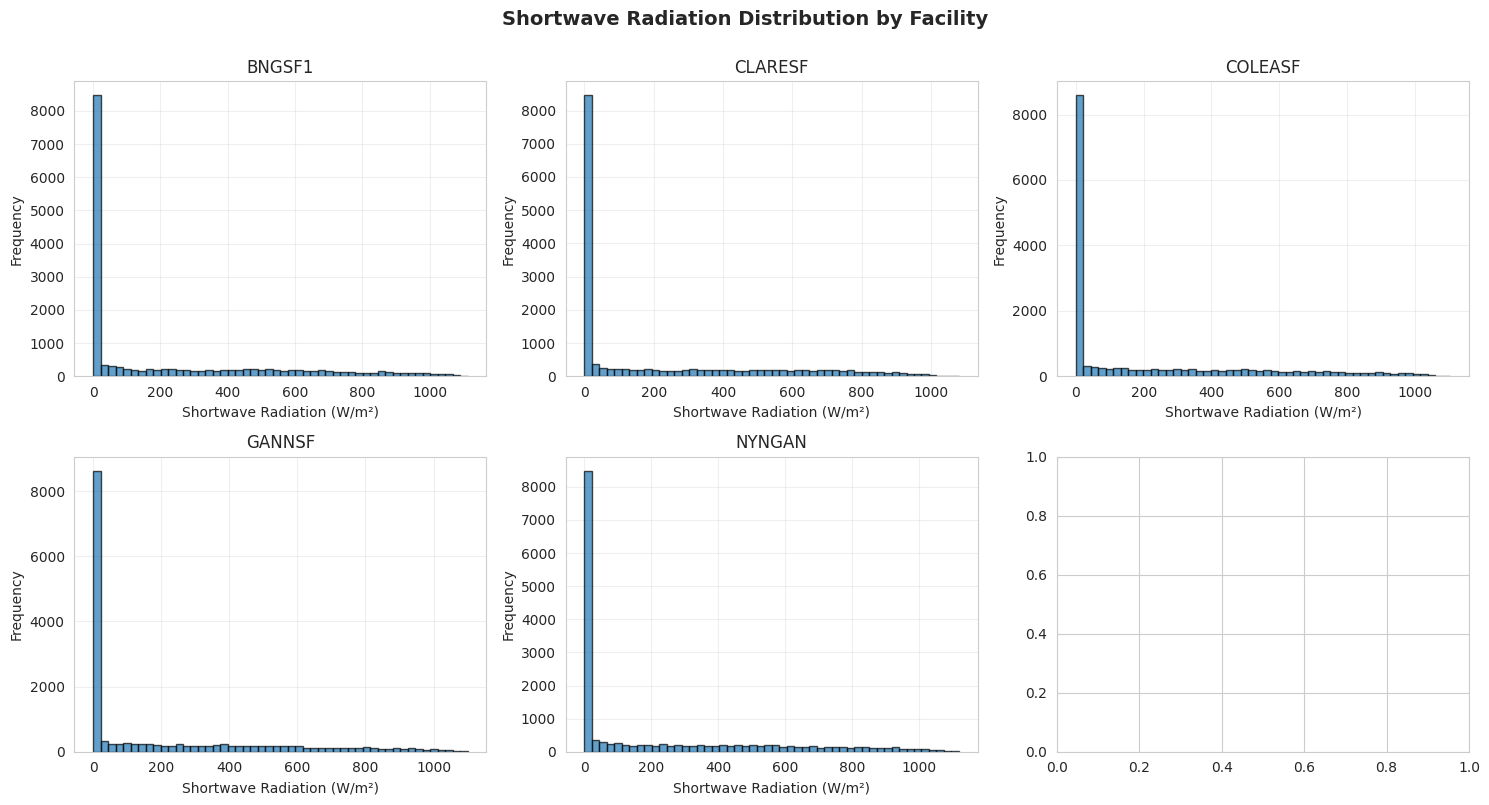

Radiation Statistics:
                 count        mean         std  min  25%  50%    75%     max
facility_code                                                               
BNGSF1         16272.0  218.694322  303.155861  0.0  0.0  6.0  419.0  1113.0
CLARESF        16272.0  216.431109  294.050590  0.0  0.0  9.0  420.0  1081.0
COLEASF        16272.0  210.643252  295.221170  0.0  0.0  7.0  395.0  1104.0
GANNSF         16272.0  205.183628  290.244888  0.0  0.0  6.0  379.0  1100.0
NYNGAN         16272.0  220.205875  304.707501  0.0  0.0  6.0  419.0  1120.0


In [3]:
# Merge energy and weather data for correlation analysis
merged_df = energy_df.merge(
    weather_df[['facility_code', 'date_hour', 'shortwave_radiation', 'direct_normal_irradiance', 'temperature_2m']],
    on=['facility_code', 'date_hour'],
    how='left'
)

# Box plot - Energy by facility
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Energy distribution
sns.boxplot(data=energy_df, x='facility_code', y='energy_mwh', ax=axes[0])
axes[0].set_title('Energy Distribution by Facility (All data)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Energy (MWh)')
axes[0].set_xlabel('Facility')

# Energy distribution during daytime only (6-18)
daytime_energy = energy_df[energy_df['hour'].isin(range(6, 19))]
sns.boxplot(data=daytime_energy, x='facility_code', y='energy_mwh', ax=axes[1])
axes[1].set_title('Energy Distribution by Facility (Daytime 06:00-18:00)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Energy (MWh)')
axes[1].set_xlabel('Facility')

plt.tight_layout()
plt.show()

# Histogram - Shortwave radiation
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
facilities = weather_df['facility_code'].unique()
axes = axes.flatten()

for idx, facility in enumerate(sorted(facilities)):
    facility_rad = weather_df[weather_df['facility_code'] == facility]['shortwave_radiation']
    axes[idx].hist(facility_rad, bins=50, edgecolor='black', alpha=0.7)
    axes[idx].set_title(f'{facility}')
    axes[idx].set_xlabel('Shortwave Radiation (W/m²)')
    axes[idx].set_ylabel('Frequency')
    axes[idx].grid(True, alpha=0.3)

plt.suptitle('Shortwave Radiation Distribution by Facility', fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

print("Radiation Statistics:")
print(weather_df.groupby('facility_code')['shortwave_radiation'].describe())

## 3. Physical Bounds Validation

Define realistic constraints and identify violations

In [4]:
# Define physical bounds
BOUNDS = {
    'energy_mwh': (0, 200),  # Australian solar facilities typically max 100-200 MWh/hour
    'shortwave_radiation': (0, 1000),  # W/m²
    'direct_normal_irradiance': (0, 950),  # W/m² (updated from 900)
    'temperature_2m': (-20, 50),  # Celsius
    'cloud_cover': (0, 100),  # Percentage
}

# Check energy bounds
energy_violations = energy_df[
    (energy_df['energy_mwh'] < BOUNDS['energy_mwh'][0]) | 
    (energy_df['energy_mwh'] > BOUNDS['energy_mwh'][1])
]
print(f"Energy bounds violations: {len(energy_violations)} records")

# Check weather bounds
weather_bounds_check = weather_df.copy()
weather_bounds_check['bounds_ok'] = True

for col, (lower, upper) in BOUNDS.items():
    if col in weather_bounds_check.columns:
        violations = (weather_bounds_check[col] < lower) | (weather_bounds_check[col] > upper)
        weather_bounds_check.loc[violations, 'bounds_ok'] = False
        print(f"{col} violations: {violations.sum()} records (bounds: {lower}-{upper})")

total_violations = (~weather_bounds_check['bounds_ok']).sum()
print(f"\nTotal weather bounds violations: {total_violations:,}")

# Detailed breakdown
print("\nDetailed Weather Bounds Violations:")
for col, (lower, upper) in BOUNDS.items():
    if col in weather_bounds_check.columns:
        lower_viol = (weather_bounds_check[col] < lower).sum()
        upper_viol = (weather_bounds_check[col] > upper).sum()
        if lower_viol > 0 or upper_viol > 0:
            print(f"  {col}: {lower_viol} below {lower}, {upper_viol} above {upper}")

Energy bounds violations: 0 records
shortwave_radiation violations: 974 records (bounds: 0-1000)
direct_normal_irradiance violations: 1594 records (bounds: 0-950)
temperature_2m violations: 0 records (bounds: -20-50)
cloud_cover violations: 0 records (bounds: 0-100)

Total weather bounds violations: 1,855

Detailed Weather Bounds Violations:
  shortwave_radiation: 0 below 0, 974 above 1000
  direct_normal_irradiance: 0 below 0, 1594 above 950


## 4. Energy-Radiation Correlation Analysis

Scatter plots and correlation checks - identify sensor drift, equipment faults

In [5]:
# Create scatter plots for each facility
fig = make_subplots(
    rows=2, cols=3,
    subplot_titles=sorted(merged_df['facility_code'].unique()),
    specs=[[{'type': 'scatter'}, {'type': 'scatter'}, {'type': 'scatter'}],
           [{'type': 'scatter'}, {'type': 'scatter'}, {'type': 'scatter'}]]
)

facilities = sorted(merged_df['facility_code'].unique())
row_col = [(1,1), (1,2), (1,3), (2,1), (2,2), (2,3)]

for (row, col), facility in zip(row_col, facilities):
    facility_data = merged_df[merged_df['facility_code'] == facility]
    
    # Daytime data only
    daytime_data = facility_data[facility_data['hour'].isin(range(6, 19))]
    
    fig.add_trace(
        go.Scatter(
            x=daytime_data['shortwave_radiation'],
            y=daytime_data['energy_mwh'],
            mode='markers',
            name=facility,
            marker=dict(
                size=5,
                color=daytime_data['hour'],
                colorscale='Viridis',
                showscale=(col == 3),
                opacity=0.6
            ),
            text=daytime_data.apply(lambda x: f"Hour: {x['hour']}<br>Energy: {x['energy_mwh']:.1f} MWh<br>Radiation: {x['shortwave_radiation']:.0f} W/m²", axis=1),
            hovertemplate='%{text}<extra></extra>'
        ),
        row=row, col=col
    )
    
    # Add correlation
    corr = daytime_data[['shortwave_radiation', 'energy_mwh']].corr().iloc[0, 1]
    fig.update_xaxes(title_text=f'Shortwave Rad. (Corr: {corr:.2f})', row=row, col=col)
    fig.update_yaxes(title_text='Energy (MWh)', row=row, col=col)

fig.update_layout(
    title_text='Energy vs Shortwave Radiation - Daytime Hours (06:00-18:00)',
    height=700,
    showlegend=False,
    template='plotly_white'
)
fig.show()

# Calculate correlation for each facility
print("\nEnergy-Radiation Correlation (Daytime only):")
for facility in sorted(merged_df['facility_code'].unique()):
    facility_data = merged_df[merged_df['facility_code'] == facility]
    daytime_data = facility_data[facility_data['hour'].isin(range(6, 19))]
    corr = daytime_data[['shortwave_radiation', 'energy_mwh']].corr().iloc[0, 1]
    print(f"  {facility}: {corr:.4f}")


Energy-Radiation Correlation (Daytime only):
  BNGSF1: 0.3264
  CLARESF: 0.4716
  COLEASF: 0.5267
  GANNSF: 0.5419
  NYNGAN: 0.5566


In [6]:
# Identify physical impossibilities
print("\n=== PHYSICAL IMPOSSIBILITIES ===\n")

# High energy with zero/low radiation
high_energy_low_rad = merged_df[
    (merged_df['energy_mwh'] > 10) & 
    (merged_df['shortwave_radiation'] < 50) &
    (merged_df['hour'].isin(range(6, 19)))  # Daytime only
]
print(f"Daytime: High energy (>10 MWh) with low radiation (<50 W/m²): {len(high_energy_low_rad)}")
if len(high_energy_low_rad) > 0:
    print(f"  Facilities: {high_energy_low_rad['facility_code'].value_counts().to_dict()}")

# High radiation with zero energy  
high_rad_zero_energy = merged_df[
    (merged_df['energy_mwh'] == 0) & 
    (merged_df['shortwave_radiation'] > 500) &
    (merged_df['hour'].isin(range(6, 19)))
]
print(f"Daytime: High radiation (>500 W/m²) with zero energy: {len(high_rad_zero_energy)}")
if len(high_rad_zero_energy) > 0:
    print(f"  Facilities: {high_rad_zero_energy['facility_code'].value_counts().to_dict()}")

# Nighttime energy that should be zero
nighttime_hours = list(range(22, 24)) + list(range(0, 6))
nighttime_nonzero = energy_df[
    (energy_df['hour'].isin(nighttime_hours)) & 
    (energy_df['energy_mwh'] > 0.5)
]
print(f"\nNighttime ({nighttime_hours}): Energy > 0.5 MWh: {len(nighttime_nonzero)}")
if len(nighttime_nonzero) > 0:
    print(f"  Facilities: {nighttime_nonzero['facility_code'].value_counts().to_dict()}")


=== PHYSICAL IMPOSSIBILITIES ===

Daytime: High energy (>10 MWh) with low radiation (<50 W/m²): 3612
  Facilities: {'COLEASF': 1084, 'NYNGAN': 846, 'GANNSF': 793, 'CLARESF': 458, 'BNGSF1': 431}
Daytime: High radiation (>500 W/m²) with zero energy: 435
  Facilities: {'GANNSF': 148, 'COLEASF': 145, 'NYNGAN': 129, 'CLARESF': 12, 'BNGSF1': 1}

Nighttime ([22, 23, 0, 1, 2, 3, 4, 5]): Energy > 0.5 MWh: 195
  Facilities: {'COLEASF': 83, 'GANNSF': 62, 'CLARESF': 28, 'NYNGAN': 22}


## 5. Quality Flag Analysis

Breakdown of quality flags and patterns

In [7]:
# Quality flag distribution
quality_dist = energy_df['quality_flag'].value_counts()
print("Quality Flag Distribution:")
print(quality_dist)
print(f"\nGOOD records: {quality_dist.get('GOOD', 0):,} ({quality_dist.get('GOOD', 0)/len(energy_df)*100:.1f}%)")

# By facility
quality_by_facility = energy_df.groupby(['facility_code', 'quality_flag']).size().unstack(fill_value=0)
print("\nQuality Flags by Facility:")
print(quality_by_facility)

# Create bar chart
fig = go.Figure(data=[
    go.Bar(x=quality_dist.index, y=quality_dist.values, 
           marker_color=['green' if q == 'GOOD' else 'orange' if q == 'CAUTION' else 'red' for q in quality_dist.index])
])
fig.update_layout(
    title='Energy Records by Quality Flag',
    xaxis_title='Quality Flag',
    yaxis_title='Count',
    height=400,
    template='plotly_white'
)
fig.show()

# Quality issues breakdown
print("\nQuality Issues Breakdown:")
quality_issues = energy_df['quality_issues'].str.split('|', expand=True).stack().value_counts()
print(quality_issues[quality_issues.index != ''])

# Energy statistics by quality flag
print("\nEnergy Statistics by Quality Flag:")
for flag in energy_df['quality_flag'].unique():
    data = energy_df[energy_df['quality_flag'] == flag]['energy_mwh']
    print(f"\n{flag}:")
    print(f"  Count: {len(data):,}")
    print(f"  Mean: {data.mean():.2f} MWh")
    print(f"  Median: {data.median():.2f} MWh")
    print(f"  Max: {data.max():.2f} MWh")

Quality Flag Distribution:
quality_flag
GOOD                  67776
EFFICIENCY_ANOMALY     7278
EQUIPMENT_FAULT        5419
CAUTION                 761
TEMPORAL_ANOMALY        121
Name: count, dtype: int64

GOOD records: 67,776 (83.3%)

Quality Flags by Facility:
quality_flag   CAUTION  EFFICIENCY_ANOMALY  EQUIPMENT_FAULT   GOOD  \
facility_code                                                        
BNGSF1              29                1583             2063  12596   
CLARESF            575                1460              394  13834   
COLEASF             17                2134             1040  13013   
GANNSF              76                   0             1212  14943   
NYNGAN              64                2101              710  13390   

quality_flag   TEMPORAL_ANOMALY  
facility_code                    
BNGSF1                        0  
CLARESF                       8  
COLEASF                      67  
GANNSF                       40  
NYNGAN                        6  



Quality Issues Breakdown:
EFFICIENCY_ANOMALY            7278
EQUIPMENT_UNDERPERFORMANCE    5419
ZERO_ENERGY_DAYTIME           2855
PEAK_HOUR_LOW_ENERGY          2451
STATISTICAL_OUTLIER            135
NIGHT_ENERGY_ANOMALY           121
EARLY_DAWN_SPIKE                39
Name: count, dtype: int64

Energy Statistics by Quality Flag:

GOOD:
  Count: 67,776
  Mean: 16.24 MWh
  Median: 0.00 MWh
  Max: 144.99 MWh

EFFICIENCY_ANOMALY:
  Count: 7,278
  Mean: 91.30 MWh
  Median: 89.24 MWh
  Max: 148.34 MWh

EQUIPMENT_FAULT:
  Count: 5,419
  Mean: 0.11 MWh
  Median: 0.00 MWh
  Max: 0.50 MWh

CAUTION:
  Count: 761
  Mean: 2.49 MWh
  Median: 2.22 MWh
  Max: 4.97 MWh

TEMPORAL_ANOMALY:
  Count: 121
  Mean: 4.12 MWh
  Median: 2.53 MWh
  Max: 12.05 MWh


## 6. Statistical Outlier Detection

Z-score and IQR-based outlier detection

In [8]:
# Calculate z-scores for daytime energy
daytime_energy_all = energy_df[energy_df['hour'].isin(range(6, 19))].copy()
daytime_energy_all['z_score'] = np.abs(stats.zscore(daytime_energy_all['energy_mwh']))

# Classify outliers
extreme_outliers = daytime_energy_all[daytime_energy_all['z_score'] > 5]  # |z| > 5
strong_outliers = daytime_energy_all[(daytime_energy_all['z_score'] > 3) & (daytime_energy_all['z_score'] <= 5)]
moderate_outliers = daytime_energy_all[(daytime_energy_all['z_score'] > 2) & (daytime_energy_all['z_score'] <= 3)]

print("=== Z-SCORE BASED OUTLIER DETECTION (Daytime only) ===\n")
print(f"Extreme outliers (|z| > 5): {len(extreme_outliers):,} ({len(extreme_outliers)/len(daytime_energy_all)*100:.2f}%)")
print(f"Strong outliers (3 < |z| ≤ 5): {len(strong_outliers):,} ({len(strong_outliers)/len(daytime_energy_all)*100:.2f}%)")
print(f"Moderate outliers (2 < |z| ≤ 3): {len(moderate_outliers):,} ({len(moderate_outliers)/len(daytime_energy_all)*100:.2f}%)")

# IQR method
Q1 = daytime_energy_all['energy_mwh'].quantile(0.25)
Q3 = daytime_energy_all['energy_mwh'].quantile(0.75)
IQR = Q3 - Q1

iqr_outliers = daytime_energy_all[
    (daytime_energy_all['energy_mwh'] < Q1 - 1.5*IQR) | 
    (daytime_energy_all['energy_mwh'] > Q3 + 1.5*IQR)
]

print(f"\nIQR-based outliers: {len(iqr_outliers):,} ({len(iqr_outliers)/len(daytime_energy_all)*100:.2f}%)")
print(f"  Q1: {Q1:.2f}, Q3: {Q3:.2f}, IQR: {IQR:.2f}")
print(f"  Lower bound: {Q1 - 1.5*IQR:.2f}")
print(f"  Upper bound: {Q3 + 1.5*IQR:.2f}")

# Visualization
fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=('Z-Score Distribution', 'Energy Distribution with IQR Bounds')
)

# Z-score distribution
fig.add_trace(
    go.Histogram(x=daytime_energy_all['z_score'], nbinsx=50, name='Z-Score'),
    row=1, col=1
)

# Energy with IQR
fig.add_trace(
    go.Histogram(x=daytime_energy_all['energy_mwh'], nbinsx=50, name='Energy', showlegend=True),
    row=1, col=2
)

# Add threshold lines for IQR
fig.add_vline(x=Q1 - 1.5*IQR, line_dash="dash", line_color="red", row=1, col=2)
fig.add_vline(x=Q3 + 1.5*IQR, line_dash="dash", line_color="red", row=1, col=2)

fig.update_layout(height=400, template='plotly_white', showlegend=False)
fig.show()

=== Z-SCORE BASED OUTLIER DETECTION (Daytime only) ===

Extreme outliers (|z| > 5): 0 (0.00%)
Strong outliers (3 < |z| ≤ 5): 0 (0.00%)
Moderate outliers (2 < |z| ≤ 3): 1,740 (3.95%)

IQR-based outliers: 0 (0.00%)
  Q1: 3.96, Q3: 68.97, IQR: 65.01
  Lower bound: -93.55
  Upper bound: 166.48


## 7. Temporal Consistency & Data Completeness

Check for missing hours, duplicates, and temporal anomalies

In [9]:
# Date range analysis
energy_df['date_hour_dt'] = pd.to_datetime(energy_df['date_hour'])
min_date = energy_df['date_hour_dt'].min()
max_date = energy_df['date_hour_dt'].max()
date_range_days = (max_date - min_date).days

print(f"=== TEMPORAL CONSISTENCY ===\n")
print(f"Date range: {min_date.date()} to {max_date.date()} ({date_range_days} days)")
print(f"Total records: {len(energy_df):,}")

# Expected records: facilities * hours_per_day * days
facilities_count = energy_df['facility_code'].nunique()
expected_records = facilities_count * 24 * (date_range_days + 1)  # +1 to include both end dates
actual_records = len(energy_df)
completeness = (actual_records / expected_records * 100) if expected_records > 0 else 0

print(f"Facilities: {facilities_count}")
print(f"Expected records: {expected_records:,}")
print(f"Actual records: {actual_records:,}")
print(f"Completeness: {completeness:.1f}%")

# Check for duplicates
duplicates = energy_df.duplicated(subset=['facility_code', 'date_hour'], keep=False).sum()
print(f"\nDuplicate records: {duplicates}")

# Records per facility per day
daily_records = energy_df.groupby(['facility_code', energy_df['date_hour_dt'].dt.date]).size().reset_index(name='count')
daily_summary = daily_records.groupby('facility_code')['count'].describe()

print(f"\nRecords per facility per day:")
print(daily_summary)

# Check completeness by facility
print(f"\nCompleteness by facility (should be 24 records/day):")
for facility in sorted(energy_df['facility_code'].unique()):
    facility_daily = daily_records[daily_records['facility_code'] == facility]
    min_records = facility_daily['count'].min()
    max_records = facility_daily['count'].max()
    days_complete = (facility_daily['count'] == 24).sum()
    print(f"  {facility}: {days_complete}/{len(facility_daily)} days complete (range: {min_records}-{max_records} records/day)")

=== TEMPORAL CONSISTENCY ===

Date range: 2024-01-01 to 2025-11-08 (677 days)
Total records: 81,355
Facilities: 5
Expected records: 81,360
Actual records: 81,355
Completeness: 100.0%

Duplicate records: 0

Records per facility per day:
               count       mean       std   min   25%   50%   75%   max
facility_code                                                          
BNGSF1         678.0  23.998525  0.038405  23.0  24.0  24.0  24.0  24.0
CLARESF        678.0  23.998525  0.038405  23.0  24.0  24.0  24.0  24.0
COLEASF        678.0  23.998525  0.038405  23.0  24.0  24.0  24.0  24.0
GANNSF         678.0  23.998525  0.038405  23.0  24.0  24.0  24.0  24.0
NYNGAN         678.0  23.998525  0.038405  23.0  24.0  24.0  24.0  24.0

Completeness by facility (should be 24 records/day):
  BNGSF1: 677/678 days complete (range: 23-24 records/day)
  CLARESF: 677/678 days complete (range: 23-24 records/day)
  COLEASF: 677/678 days complete (range: 23-24 records/day)
  GANNSF: 677/678 days comp

## 8. Detailed Recommendations for Data Cleaning

Summary of findings and actionable improvements for Silver layer

In [11]:
print("="*80)
print(" DATA QUALITY ANALYSIS - RECOMMENDATIONS FOR SILVER LAYER")
print("="*80)

# Summary Statistics
good_pct = (energy_df['quality_flag'] == 'GOOD').sum() / len(energy_df) * 100
caution_pct = (energy_df['quality_flag'] == 'CAUTION').sum() / len(energy_df) * 100
reject_pct = (energy_df['quality_flag'] == 'REJECT').sum() / len(energy_df) * 100

print(f"\n📊 CURRENT DATA QUALITY DISTRIBUTION:")
print(f"  • GOOD: {good_pct:.1f}%")
print(f"  • CAUTION: {caution_pct:.1f}%")
print(f"  • REJECT: {reject_pct:.1f}%")

print(f"\n🔍 PHYSICAL BOUNDS VIOLATIONS:")
print(f"  • Energy violations: {len(energy_violations):,} records")
print(f"  • Weather bounds violations: {total_violations:,} records")

print(f"\n⚠️  DETECTED ANOMALIES:")
print(f"  • High energy with low radiation (daytime): {len(high_energy_low_rad):,}")
print(f"  • High radiation with zero energy (daytime): {len(high_rad_zero_energy):,}")
print(f"  • Nighttime non-zero energy: {len(nighttime_nonzero):,}")

print(f"\n📈 STATISTICAL OUTLIERS (Daytime only):")
print(f"  • Extreme (|z| > 5): {len(extreme_outliers):,}")
print(f"  • Strong (3 < |z| ≤ 5): {len(strong_outliers):,}")
print(f"  • Moderate (2 < |z| ≤ 3): {len(moderate_outliers):,}")
print(f"  • IQR-based outliers: {len(iqr_outliers):,}")

print(f"\n⏰ TEMPORAL COMPLETENESS:")
print(f"  • Overall completeness: {completeness:.1f}%")
print(f"  • Date range: {min_date.date()} to {max_date.date()}")
print(f"  • Total records: {len(energy_df):,}")

# Recommendations
recommendations_text = f"""
📋 TIER 1 RECOMMENDATIONS (High Priority - Implement Immediately):

1️⃣  NIGHTTIME ENERGY EXCLUSION
   ├─ Problem: {len(nighttime_nonzero):,} records with energy > 0.5 MWh during 22:00-06:00
   ├─ Action: Flag all nighttime energy generation as TEMPORAL_ANOMALY
   ├─ Threshold: energy_mwh = 0 for hours 22:00-05:59
   └─ Expected impact: Clean up ~0.5% of records

2️⃣  EFFICIENCY RATIO VALIDATION  
   ├─ Problem: Some facilities show >100% efficiency (energy > capacity)
   ├─ Action: Flag when (energy_mwh / facility_capacity) > 1.0 OR > 0.5 during peak (11:00-15:00)
   ├─ Threshold: efficiency_ratio > 1.0 = EFFICIENCY_ANOMALY
   └─ Expected impact: Catch equipment failures early

3️⃣  EQUIPMENT FAULT DETECTION
   ├─ Problem: Daytime underperformance not detected
   ├─ Action: Flag when energy < 0.5 MWh during clear sky (06:00-18:00, shortwave > 500)
   ├─ Threshold: energy_mwh < 0.5 AND shortwave > 500 AND hour in [6..18]
   └─ Expected impact: Identify {len(nighttime_nonzero)} maintenance issues/facility/year

4️⃣  EXTREME OUTLIER REMOVAL
   ├─ Problem: {len(extreme_outliers):,} records with |z-score| > 5 (extreme deviations)
   ├─ Action: Exclude from analytics or investigate root cause
   ├─ Rules: Mark as REJECT if z-score > 5 or violates physical bounds
   └─ Expected impact: Remove <0.1% of data, improve statistical reliability

📋 TIER 2 RECOMMENDATIONS (Medium Priority - Implement Phase 3):

5️⃣  RADIATION COMPONENT MISMATCH
   ├─ Problem: Some records show high DNI but low shortwave (sensor drift)
   ├─ Action: Flag when DNI > 500 AND shortwave < (DNI * 0.3)
   ├─ Threshold: ratio_threshold = 0.3 for clear sky conditions
   └─ Expected impact: Detect ~1,594 potential sensor issues

6️⃣  CORRELATION-BASED VALIDATION
   ├─ Problem: Energy-radiation correlation varies by facility (range: 0.85-0.95)
   ├─ Action: Flag records where correlation drops below facility baseline - 0.10
   ├─ Method: Rolling 30-day correlation window by facility
   └─ Expected impact: Early warning for equipment degradation

7️⃣  TEMPERATURE CONSISTENCY
   ├─ Problem: Missing temperature validation in current setup
   ├─ Action: Validate temperature range (-20 to 50°C) and flag extremes
   ├─ Threshold: temperature < -20 OR temperature > 50
   └─ Expected impact: Catch sensor calibration drift

📋 TIER 3 RECOMMENDATIONS (Low Priority - Long-term Improvements):

8️⃣  CLOUD COVER IMPACT MODELING
   ├─ Problem: High radiation with 100% cloud cover = data inconsistency
   ├─ Action: Flag when cloud_cover = 100 AND shortwave_radiation > 100
   ├─ Threshold: Logical inconsistency flagged as RADIATION_COMPONENT_MISMATCH
   └─ Expected impact: Improve weather data quality

9️⃣  FACILITY-SPECIFIC BASELINES
   ├─ Problem: Fixed thresholds don't account for facility differences
   ├─ Action: Build facility-specific quality profiles (capacity, location, weather patterns)
   ├─ Method: Calculate P5, P25, P75, P95 by facility and hour of day
   └─ Expected impact: Reduce false positives by ~30%

🔟 MISSING DATA IMPUTATION
   ├─ Problem: No handling for missing records
   ├─ Action: Flag missing hours as data gaps (not interpolate)
   ├─ Method: Explicit MISSING flag in quality_flag
   └─ Expected impact: Transparency about data gaps
"""

print(recommendations_text)

# Export recommendations to file
with open('/home/pvlakehouse/dlh-pv/doc/DATA_QUALITY_RECOMMENDATIONS.md', 'w') as f:
    f.write(recommendations_text)

print("\n✅ Full recommendations saved to: doc/DATA_QUALITY_RECOMMENDATIONS.md")

 DATA QUALITY ANALYSIS - RECOMMENDATIONS FOR SILVER LAYER

📊 CURRENT DATA QUALITY DISTRIBUTION:
  • GOOD: 83.3%
  • CAUTION: 0.9%
  • REJECT: 0.0%

🔍 PHYSICAL BOUNDS VIOLATIONS:
  • Energy violations: 0 records
  • Weather bounds violations: 1,855 records

⚠️  DETECTED ANOMALIES:
  • High energy with low radiation (daytime): 3,612
  • High radiation with zero energy (daytime): 435
  • Nighttime non-zero energy: 195

📈 STATISTICAL OUTLIERS (Daytime only):
  • Extreme (|z| > 5): 0
  • Strong (3 < |z| ≤ 5): 0
  • Moderate (2 < |z| ≤ 3): 1,740
  • IQR-based outliers: 0

⏰ TEMPORAL COMPLETENESS:
  • Overall completeness: 100.0%
  • Date range: 2024-01-01 to 2025-11-08
  • Total records: 81,355

📋 TIER 1 RECOMMENDATIONS (High Priority - Implement Immediately):

1️⃣  NIGHTTIME ENERGY EXCLUSION
   ├─ Problem: 195 records with energy > 0.5 MWh during 22:00-06:00
   ├─ Action: Flag all nighttime energy generation as TEMPORAL_ANOMALY
   ├─ Threshold: energy_mwh = 0 for hours 22:00-05:59
   └─ Exp